In [271]:
"""
http://pymolwiki.org/index.php/plot_noe

(c) 2011-09-23 by Justin L Lorieau
(c) 2012-10-31 by Thomas Holder

License: BSD-2-Clause
"""

from __future__ import print_function

from pymol import cmd, CmdException, stored
import re
import shlex
import pandas as pd, numpy as np


def plot_noe(filename, line_color=None, line_width='1.0', advanced_coloring=0, single=0, quiet=1, aria=0, per_atom=0,
             per_residue=1):
    """
DESCRIPTION

    A function for plotting XPLOR NOE restraints on a structure

ARGUMENTS

    filename = string: The filename of the NOE retraint file in XPLOR NIH format.

    line_color = string: The color for the NOE lines. {default: yellow}

    line_width = float: The thickness of the NOE lines. {default: 1.0}

    advanced_coloring = color restraints by distance.

    single = string: create a single object for all restraints.

    aria = integer: Name NOEs after Aria IDs.

    per_atom: Group NOEs on atom basis

    per_residue: Group NOEs on residue basis (default)

NOE Restraint Format Example

    assign (residue 5 and name HB#) (residue 21 and name HA) 3.0 0.7 0.7

EXAMPLE

    PyMOL> plot_noe noe_short.tbl
    """

    single, quiet, aria, per_residue, per_atom, advanced_coloring = \
        int(single), int(quiet), int(aria), int(per_residue), int(per_atom), int(advanced_coloring)

    count = 0

    if advanced_coloring == 1:
        cmd.set("group_auto_mode", 2)

    rgx_assi = re.compile("\s*[asignASIGN]+\s+.*")
    rgx_or = re.compile("\s*[orOR]+\s+.*")
    rgx_bracket = re.compile("(\(|\))")
    rgx_tick = re.compile("(\w)\'")

    restraint_line = None
    restraint_block = []
    restraints_blocks = []

    for line in open(filename):
        if rgx_assi.match(line):
            if restraint_line:
                restraint_block.append(rgx_tick.sub("\g<1>^", rgx_bracket.sub(" ", restraint_line)))
                restraints_blocks.append(restraint_block)
            restraint_block = []
            restraint_line = line
        elif rgx_or.match(line):
            restraint_block.append(rgx_tick.sub("\g<1>^", rgx_bracket.sub(" ", restraint_line)))
            restraint_line = line
        else:
            restraint_line += line

    restraint_block.append(rgx_tick.sub("\g<1>^", rgx_bracket.sub(" ", restraint_line)))
    restraints_blocks.append(restraint_block)

    for restraint_block in restraints_blocks:
        restraints = {"connections": []}

        try:
            shlex_split = shlex.split(restraint_block[0])
        except ValueError:
            print('Cannot process "%s"' % restraint_block[0])
        try:
            restraints["distance"] = float(shlex_split[11].strip())
        except IndexError:
            print('Cannot process "%s"' % "".join(restraint_block))
            continue
        except ValueError:
            try:
                restraints["distance"] = float(shlex_split[17].strip())
            except ValueError:
                print("Failed to extract distance, setting to 1A")
                restraints["distance"] = 1

        if len(shlex_split) > 20:
            restraints["ID"] = shlex_split[26][3:-1].strip()
        else:
            restraints["ID"] = str(count + 1)

        for restraint_line in restraint_block:
            distance = {}
            try:
                shlex_split = shlex.split(restraint_line)

                if len(shlex_split) > 6:
                    if shlex_split[1].strip().lower() == shlex_split[9].strip().lower() == "segid":
                        distance["src_segid"] = shlex_split[2].strip()
                        distance["src_resid"] = shlex_split[5].strip()
                        distance["src_atom"] = shlex_split[8].strip().replace("^", "'")
                        distance["dst_segid"] = shlex_split[10].strip()
                        distance["dst_resid"] = shlex_split[13].strip()
                        distance["dst_atom"] = shlex_split[16].strip().replace("^", "'")
                    else:
                        distance["src_segid"] = "A"
                        distance["src_resid"] = shlex_split[2].strip()
                        distance["src_atom"] = shlex_split[5].strip().replace("^", "'")
                        distance["dst_segid"] = "A"
                        distance["dst_resid"] = shlex_split[7].strip()
                        distance["dst_atom"] = shlex_split[10].strip().replace("^", "'")

                else:
                    print('Cannot process "%s"' % restraint_line)
                    continue
            except IndexError:
                print('Cannot process "%s"' % restraint_line)
                continue
            except ValueError:
                print('Cannot process "%s"' % restraint_line)
                continue

            restraints["connections"].append(distance)

        count += _draw_restraint(
            restraints,
            line_color,
            line_width,
            single,
            quiet,
            per_residue,
            per_atom,
            advanced_coloring
        )

    if not quiet:
        print(' Info: Created distance objects for %d restraints' % count)

    cmd.order("NOE*", "yes")


def _draw_restraint(restraints, line_color, line_width, single, quiet, per_residue, per_atom, advanced_coloring):
    cnt = 0
    for restraint in restraints["connections"]:
        cnt += 1
        sele1 = 'segid %s and resi %s and name %s' % (
            restraint["src_segid"], restraint["src_resid"], restraint["src_atom"].replace("#", "*")
        )
        sele2 = 'segid %s and resi %s and name %s' % (
            restraint["dst_segid"], restraint["dst_resid"], restraint["dst_atom"].replace("#", "*")
        )
        print("sele1 sele2",sele1,sele2)
        if line_color is None:
            if advanced_coloring == 1:
                if restraints["distance"] < 2 or restraints["distance"] > 6:
                    line_color = "red"
                elif 5 < restraints["distance"] < 6:
                    line_color = "orange"
                else:
                    line_color = "splitpea"
            else:
                line_color = "yellow"

        if per_atom or per_residue:
            for x, y, z in [
                [restraint["dst_segid"], restraint["dst_resid"], restraint["dst_atom"]],
                [restraint["src_segid"], restraint["src_resid"], restraint["src_atom"]]
            ]:
                if per_atom:
                    label = "NOE_%s_%s_%s" % (x, y, z)
                elif per_residue:
                    label = "NOE_%s_%s" % (x, y)
                if advanced_coloring == 1:
                    label += ".%s_%i" % (restraints["ID"], cnt)

                try:
                    cmd.distance(label, sele1, sele2, quiet=quiet,
                                 width=line_width, gap=0, label=0)
                    _color_restraint(label, line_color)
                except CmdException:
                    print('FAILED: %s - %s' % (sele1, sele2))
                    print(restraints["ID"])
                    return 0

        else:
            if single:
                label = "NOE"

            else:
                label = "NOE_" + restraints["ID"]

            try:
                cmd.distance(label, sele1, sele2, quiet=quiet,
                             width=line_width, gap=0, label=0)
                _color_restraint(label, line_color)
            except CmdException:
                print('FAILED: %s - %s' % (sele1, sele2))
                print(restraints["ID"])
                return 0

    return 1


def _color_restraint(object_name, color="yellow"):
    cmd.set("dash_color", color, object_name)


#cmd.extend("plot_noe", plot_noe)

def noe_tbl_to_df(filename):
    count = 0
    noedf = pd.DataFrame()

    rgx_assi = re.compile("\s*[asignASIGN]+\s+.*")
    rgx_or = re.compile("\s*[orOR]+\s+.*")
    rgx_bracket = re.compile("(\(|\))")
    rgx_tick = re.compile("(\w)\'")

    restraint_line = None
    restraint_block = []
    restraints_blocks = []

    for line in open(filename):
        if rgx_assi.match(line):
            if restraint_line:
                restraint_block.append(rgx_tick.sub("\g<1>^", rgx_bracket.sub(" ", restraint_line)))
                restraints_blocks.append(restraint_block)
            restraint_block = []
            restraint_line = line
        elif rgx_or.match(line):
            restraint_block.append(rgx_tick.sub("\g<1>^", rgx_bracket.sub(" ", restraint_line)))
            restraint_line = line
        else:
            restraint_line += line

    restraint_block.append(rgx_tick.sub("\g<1>^", rgx_bracket.sub(" ", restraint_line)))
    restraints_blocks.append(restraint_block)

    for restraint_block in restraints_blocks:
        restraints = {"connections": []}

        try:
            shlex_split = shlex.split(restraint_block[0])
        except ValueError:
            print('Cannot process "%s"' % restraint_block[0])
        try:
            restraints["distance"] = float(shlex_split[11].strip())
        except IndexError:
            print('Cannot process "%s"' % "".join(restraint_block))
            continue
        except ValueError:
            try:
                restraints["distance"] = float(shlex_split[17].strip())
            except ValueError:
                print("Failed to extract distance, setting to 1A")
                restraints["distance"] = 1

        if len(shlex_split) > 20:
            restraints["ID"] = shlex_split[26][3:-1].strip()
        else:
            restraints["ID"] = str(count + 1)

        for restraint_line in restraint_block:
            distance = {}
            try:
                shlex_split = shlex.split(restraint_line)

                if len(shlex_split) > 6:
                    if shlex_split[1].strip().lower() == shlex_split[9].strip().lower() == "segid":
                        distance["src_segid"] = shlex_split[2].strip()
                        distance["src_resid"] = shlex_split[5].strip()
                        distance["src_atom"] = shlex_split[8].strip().replace("^", "'")
                        distance["dst_segid"] = shlex_split[10].strip()
                        distance["dst_resid"] = shlex_split[13].strip()
                        distance["dst_atom"] = shlex_split[16].strip().replace("^", "'")
                    else:
                        distance["src_segid"] = "A"
                        distance["src_resid"] = shlex_split[2].strip()
                        distance["src_atom"] = shlex_split[5].strip().replace("^", "'")
                        distance["dst_segid"] = "A"
                        distance["dst_resid"] = shlex_split[7].strip()
                        distance["dst_atom"] = shlex_split[10].strip().replace("^", "'")

                else:
                    print('Cannot process "%s"' % restraint_line)
                    continue
            except IndexError:
                print('Cannot process "%s"' % restraint_line)
                continue
            except ValueError:
                print('Cannot process "%s"' % restraint_line)
                continue

            restraints["connections"].append(distance)
            distance['ID'] = restraints['ID']
            distance['distance'] = restraints['distance']
            count = count + 1
            noedf = pd.concat([noedf,pd.DataFrame.from_dict([distance])])

    return noedf.reset_index(drop=True)

def get_dist(row):
    sel1 = 'segid '+row['src_segid']+' & resi '+row['src_resid']+' & name '+row['src_atom']
    sel2 = 'segid '+row['dst_segid']+' & resi '+row['dst_resid']+' & name '+row['dst_atom']
    return cmd.distance("noe_dist_"+row['src_resid'],sel1,sel2)



# iterate i. 46-53+134-140 and n. ca, cmd.enable('NOE_A_'+str(resi))

In [ ]:
#https://bmrb.pdbj.org/ref_info/atom_nom.tbl cleaned up for easier parsing --> atom_nom.csv
atom_nom = pd.read_csv('/home/tuttle/data/bin/atom_nom.csv',skip_blank_lines=True,skiprows=58,delimiter='\t').drop(['Unnamed: 1'],axis=1).dropna(how='all')

seq = 'FACKTANGTAIPIGGGSANVYVNLAPVVNVGQNLVVDLSTQIFCHNDYPETITDYVTLQRGSAYGGVLSNFSGTVKYSGSSYPFPTTSETPRVVYNSRTDKPWPVALYLTPVSSAGGVAIKAGSLIAVLILRQTNNYNSDDFQFVWNIYANNDVVVPTGG'
noes = noe_tbl_to_df('NOEfinalFimH_conv_3zpd.tbl')
noes['src_resn'] = noes['src_resid'].map(lambda x: seq[int(x)-1])
noes['dst_resn'] = noes['dst_resid'].map(lambda x: seq[int(x)-1])
noes = noes.rename(columns={'src_atom':'src_XPLOR','dst_atom':'dst_XPLOR'})


test = noes.copy()
test = pd.merge(left=test,right=atom_nom[['# A.A.','BMRB','XPLOR']],how='left',left_on=['src_resn','src_XPLOR'],right_on=['# A.A.','XPLOR']).rename(columns={'BMRB':'src_atom'})
test['src_atom'] = np.where(test['src_XPLOR'].str.contains('*',regex=False),test['src_XPLOR'],test['src_atom'])
test = test.drop(columns=['# A.A.','XPLOR',])
test = pd.merge(left=test,right=atom_nom[['# A.A.','BMRB','XPLOR']],how='left',left_on=['dst_resn','dst_XPLOR'],right_on=['# A.A.','XPLOR']).rename(columns={'BMRB':'dst_atom'})
test['dst_atom'] = np.where(test['dst_XPLOR'].str.contains('*',regex=False),test['dst_XPLOR'],test['dst_atom'])
test = test.drop(columns=['# A.A.','XPLOR',])
#test[test['src_resid']=='3']

cmd.reinitialize()
cmd.load('3zpd.cif')

test['dist'] = test.apply(get_dist,axis=1)
test

cmd.save('FimH_3zpd_NOEs.pse') 

In [263]:
'+'.join(sorted(test[test['dist']>8]['src_resid'].unique()))


'105+106+107+109+11+13+131+18+2+20+21+24+25+34+36+42+56+58+59+6+62+68+71+77'

In [264]:
print(test['distance'].mean(),test['distance'].std())
print(test['distance'].min(),test['distance'].max())
test[test['distance']==2.1]

3.052911077455647 0.38546481283392847
2.1 4.0


,src_segid,src_resid,src_XPLOR,dst_segid,dst_resid,dst_XPLOR,ID,distance,src_resn,dst_resn,src_atom,dst_atom,dist
155,A,9,HA,A,10,HN,156,2.1,T,A,HA,H,2.106660
856,A,72,HA,A,73,HN,857,2.1,S,G,HA,H,2.165567
3826,A,25,HB*,A,34,HD*,3827,2.1,A,L,HB*,HD*,4.793032


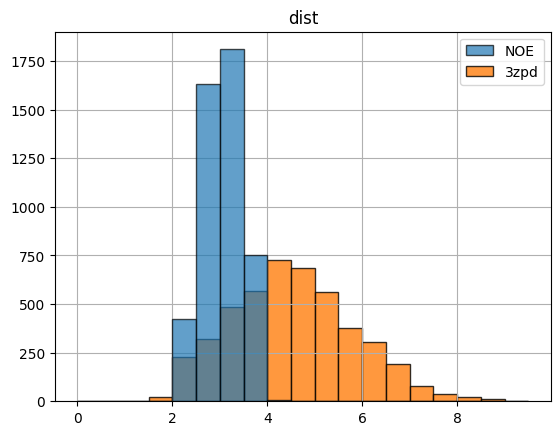

In [265]:
import matplotlib.pyplot as plt

bins = np.arange(0,10,0.5)
fig,ax = plt.subplots()
test.hist('distance',ax=ax,alpha=0.7,zorder=10,bins=bins,edgecolor='k',label='NOE')
test.hist('dist',ax=ax,alpha=0.8,bins=bins,edgecolor='k',label='3zpd');
ax.legend();

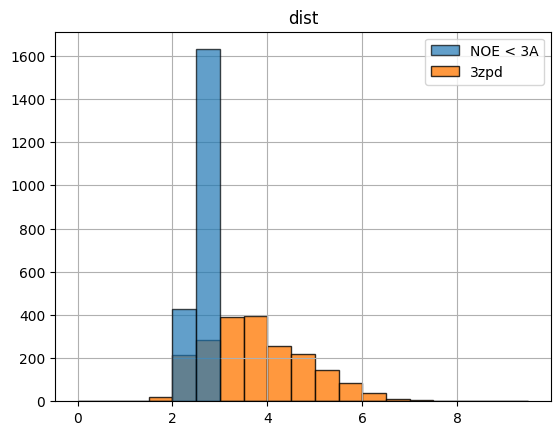

In [266]:
import matplotlib.pyplot as plt

bins = np.arange(0,10,0.5)
fig,ax = plt.subplots()
test[test['distance']<3].hist('distance',ax=ax,alpha=0.7,zorder=10,bins=bins,edgecolor='k',label='NOE < 3A')
test[test['distance']<3].hist('dist',ax=ax,alpha=0.8,bins=bins,edgecolor='k',label='3zpd');
ax.legend();

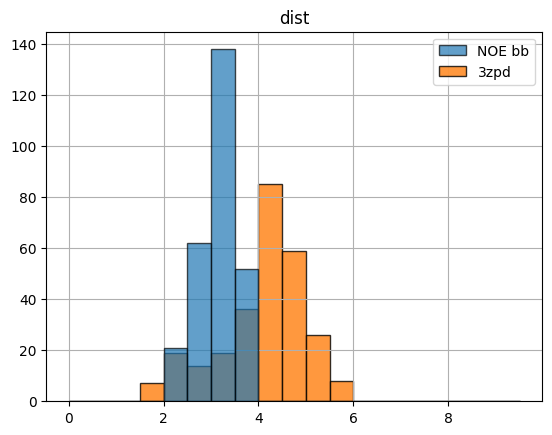

In [267]:
import matplotlib.pyplot as plt

bins = np.arange(0,10,0.5)
fig,ax = plt.subplots()
test[(test['src_atom']=='H') & (test['dst_atom']=='H')].hist('distance',ax=ax,alpha=0.7,zorder=10,bins=bins,edgecolor='k',label='NOE bb')
test[(test['src_atom']=='H') & (test['dst_atom']=='H')].hist('dist',ax=ax,alpha=0.8,bins=bins,edgecolor='k',label='3zpd');
ax.legend();